# Chapter 7 — Dimension Reduction (Programming: Exercises 3 & 5)

**Tasks**
- **Exercise 3**: For two given matrices, compute the best rank‑1 approximation in 2‑norm via SVD; verify the Eckart–Young error equals the next singular value.
- **Exercise 5**: Load the “mandrill” test image (or a robust fallback), convert to grayscale, and display rank‑\(k\) SVD approximations for \(k=5,10,15,20\).

---


In [1]:
# If needed, uncomment to install packages locally
# %pip install numpy matplotlib scikit-image

import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=6, suppress=True)


## Exercise 3 — Best rank‑1 approximation (2‑norm)

For a matrix \(A\) with SVD \(A=U\Sigma V^\top\), the best rank‑1 approximation in spectral norm is
\(\widehat{A}_1=\sigma_1\,u_1 v_1^\top\), and the optimal error equals \(\|A-\widehat{A}_1\|_2=\sigma_2\) (Eckart–Young).

We apply this to

- (a) \(A=\begin{bmatrix}1&5\\ 5&1\end{bmatrix}\),
- (b) \(A=\begin{bmatrix}1&5\\ 0&1\end{bmatrix}\).

In [2]:
def best_rank1(A):
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    A1 = (U[:, [0]] * s[0]) @ Vt[[0], :]
    err_exact = s[1] if s.size > 1 else 0.0
    err_meas = np.linalg.norm(A - A1, 2)
    return s, A1, err_exact, err_meas, U[:,0], Vt[0,:]

# (a)
A_a = np.array([[1., 5.],
                [5., 1.]])
s_a, A1_a, err_exact_a, err_meas_a, u1_a, v1_a = best_rank1(A_a)
print("=== (a) A = [[1,5],[5,1]] ===")
print("singular values:", s_a)
print("best rank-1 A1:\n", A1_a)
print("Eckart–Young σ2:", err_exact_a, " measured ||A-A1||_2:", err_meas_a)

# (b)
A_b = np.array([[1., 5.],
                [0., 1.]])
s_b, A1_b, err_exact_b, err_meas_b, u1_b, v1_b = best_rank1(A_b)
print("\n=== (b) A = [[1,5],[0,1]] ===")
print("singular values:", s_b)
print("best rank-1 A1:\n", A1_b)
print("Eckart–Young σ2:", err_exact_b, " measured ||A-A1||_2:", err_meas_b)


=== (a) A = [[1,5],[5,1]] ===
singular values: [6. 4.]
best rank-1 A1:
 [[3. 3.]
 [3. 3.]]
Eckart–Young σ2: 3.999999999999999  measured ||A-A1||_2: 4.0

=== (b) A = [[1,5],[0,1]] ===
singular values: [5.192582 0.192582]
best rank-1 A1:
 [[0.964238 5.006887]
 [0.185695 0.964238]]
Eckart–Young σ2: 0.192582403567252  measured ||A-A1||_2: 0.19258240356725206


## Exercise 5 — Rank‑\(k\) SVD image approximations

We attempt to load the **mandrill** test image. If it is unavailable, we fall back to a well‑known sample image (`scikit-image` or `scipy.misc`), and if that also fails, we generate a synthetic grayscale pattern. The image is converted to float in \([0,1]\), then reconstructed using top \(k\) singular values for \(k\in\{5,10,15,20\}\).

Each reconstruction is shown in a separate figure (no subplots), following the constraints.


Image shape: (768, 1024) dtype: float64 min/max: (0.001172156862745098, 0.9929941176470588)


C:\Users\pengu\AppData\Local\Temp\ipykernel_25084\1096825724.py:22: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  img = misc.face()


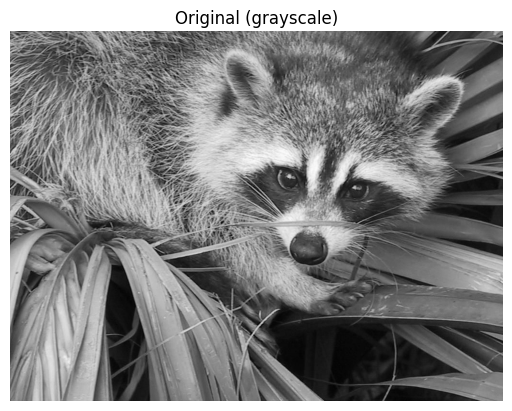

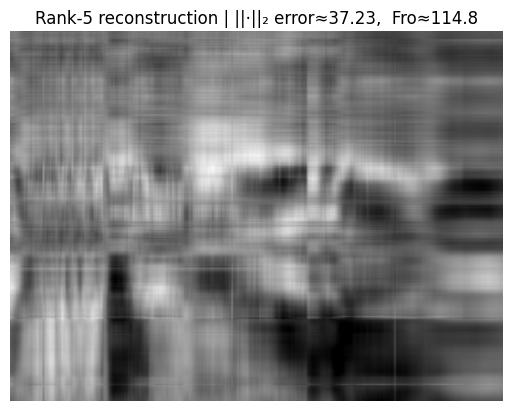

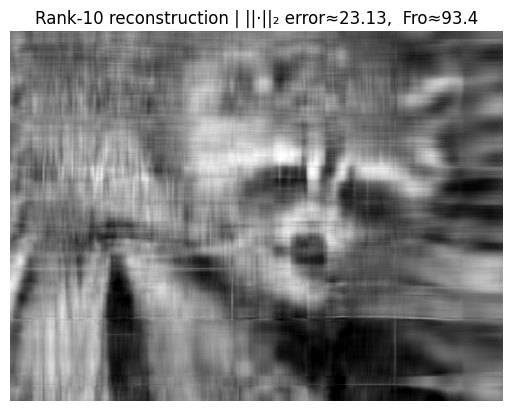

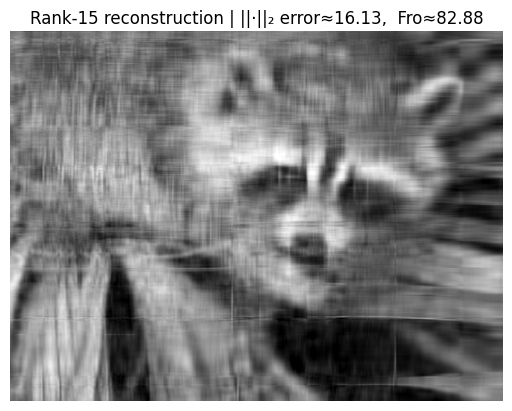

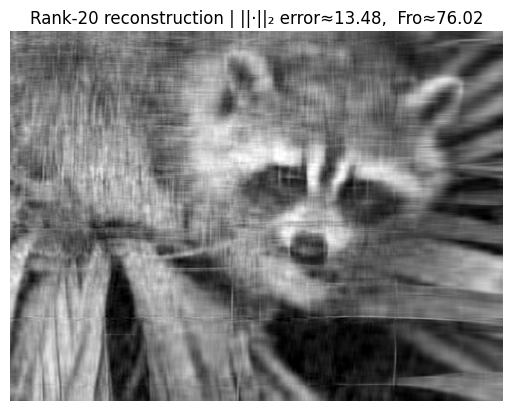

In [3]:
def load_grayscale_image():
    # Try scikit-image mandrill
    try:
        from skimage import data, color, img_as_float
        try:
            img = data.mandrill()
        except Exception:
            # fallbacks available in most installs
            try:
                img = data.camera()
            except Exception:
                img = data.astronaut()
        if img.ndim == 3:
            img = color.rgb2gray(img_as_float(img))
        else:
            img = img_as_float(img)
        return np.clip(img, 0.0, 1.0)
    except Exception:
        # Try scipy.misc.face (RGB raccoon)
        try:
            from scipy import misc
            img = misc.face()
            img = img.astype(float) / 255.0
            if img.ndim == 3:
                img = 0.2989*img[...,0] + 0.5870*img[...,1] + 0.1140*img[...,2]
            return np.clip(img, 0.0, 1.0)
        except Exception:
            # Synthetic pattern (deterministic)
            n = 512
            y, x = np.mgrid[0:n, 0:n]
            g = np.sin(0.07*x) + np.cos(0.11*y) + np.sin(0.03*x*y)
            g -= g.min(); g /= g.max()
            return g

def svd_rank_k(img, k):
    U, s, Vt = np.linalg.svd(img, full_matrices=False)
    return (U[:, :k] * s[:k]) @ Vt[:k, :]

img = load_grayscale_image()
print("Image shape:", img.shape, "dtype:", img.dtype, "min/max:", (float(img.min()), float(img.max())))

# Display original
plt.figure()
plt.imshow(img, cmap="gray", vmin=0.0, vmax=1.0)
plt.title("Original (grayscale)")
plt.axis("off")
plt.show()

for k in [5, 10, 15, 20]:
    rec = svd_rank_k(img, k)
    err = np.linalg.norm(img - rec, ord=2)  # spectral norm
    fro = np.linalg.norm(img - rec, ord="fro")
    plt.figure()
    plt.imshow(rec, cmap="gray", vmin=0.0, vmax=1.0)
    plt.title(f"Rank-{k} reconstruction | ||·||₂ error≈{err:.4g},  Fro≈{fro:.4g}")
    plt.axis("off")
    plt.show()
